# Baseline Subproject - Fine Tuning

## Data Loading

In [1]:
import pandas as pd
import torch
from torch.optim import AdamW  # Import PyTorch's AdamW
from torch.utils.data import DataLoader, Dataset

from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

from functions.fine_tune_model import calculate_lengths

In [2]:
# Load the datasets
train_data = pd.read_csv("cnndm/train_data_base.csv", sep=';')
valid_data = pd.read_csv("cnndm/valid_data_base.csv", sep=';')
test_data = pd.read_csv("cnndm/test_data_base.csv", sep=';')

In [3]:
print(train_data.isna().sum())
missing_rows = train_data[train_data.isna().any(axis=1)]


Unnamed: 0    0
article       0
highlights    0
label         0
dtype: int64


In [4]:
train_data.head()

,Unnamed: 0,article,highlights,label
0,1,(CNN) -- Police and FBI agents are investigati...,Empty anti-tank weapon turns up in front of Ne...,0
1,2,"BREMEN, Germany -- Carlos Alberto, who scored ...",Werder Bremen pay a club record $10.7 million ...,0
2,3,WASHINGTON (CNN) -- Vice President Dick Cheney...,President Bush will have a routine colonoscopy...,0
3,4,"SAN FRANCISCO, California (CNN) -- A magnitud...","2,000 customers without electricity, power com...",0
4,5,(CNN) -- At least 14 people were killed and 60...,Bomb victims waiting for presidential visit .\...,0


## Model and Tokenizer Loading

In [5]:
LONG_FORMER = False

In [6]:
if LONG_FORMER:

    from transformers import LongformerTokenizer, LongformerForSequenceClassification #, AdamW
    # Load tokenizer
    tokenizer = LongformerTokenizer.from_pretrained("allenai/longformer-base-4096")

    # Load Longformer model for classification
    model = LongformerForSequenceClassification.from_pretrained(
        "allenai/longformer-base-4096",
        num_labels=2  # Binary classification
    )

    # Check model details
    #print(model.config)

else:
    from transformers import BertTokenizer, BertForSequenceClassification #, AdamW
    tokenizer = BertTokenizer.from_pretrained("prajjwal1/bert-tiny")
    model = BertForSequenceClassification.from_pretrained("prajjwal1/bert-tiny", num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Token Analysis 

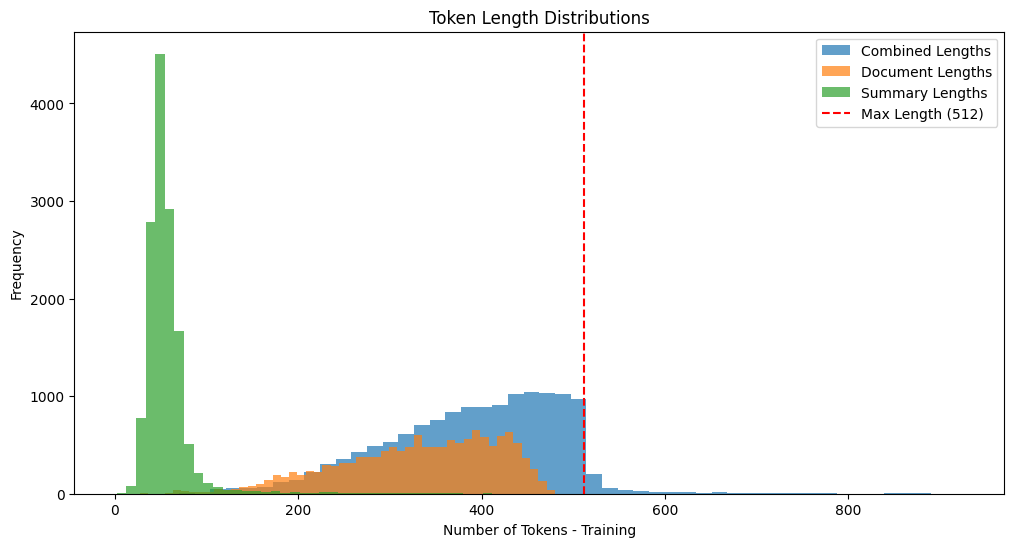

       Document Lengths  Summary Lengths  Combined Lengths
count      13978.000000     13978.000000      13978.000000
mean         330.654314        56.761268        390.415582
std           85.820662        31.512637         95.101243
min           27.000000         2.000000         70.000000
25%          272.000000        43.000000        327.250000
50%          342.000000        52.000000        401.000000
75%          400.000000        62.000000        462.000000
max          480.000000       527.000000        924.000000


In [8]:
# Calculate token lengths for documents and summaries
doc_lengths = calculate_lengths(train_data, tokenizer, column_name='article')
summ_lengths = calculate_lengths(train_data, tokenizer, column_name='highlights')

# Combine lengths for total sequence lengths
combined_lengths = [d + s + 3 for d, s in zip(doc_lengths, summ_lengths)]  # +3 for [CLS], [SEP], [SEP]

# Create a DataFrame for analysis
lengths_df = pd.DataFrame({
    'Document Lengths': doc_lengths,
    'Summary Lengths': summ_lengths,
    'Combined Lengths': combined_lengths
})

# Plot distributions
plt.figure(figsize=(12, 6))
plt.hist(lengths_df['Combined Lengths'], bins=50, alpha=0.7, label='Combined Lengths')
plt.hist(lengths_df['Document Lengths'], bins=50, alpha=0.7, label='Document Lengths')
plt.hist(lengths_df['Summary Lengths'], bins=50, alpha=0.7, label='Summary Lengths')
plt.axvline(x=512, color='red', linestyle='--', label='Max Length (512)')
plt.xlabel('Number of Tokens - Training')
plt.ylabel('Frequency')
plt.legend()
plt.title('Token Length Distributions')
plt.show()

# Print statistics
print(lengths_df.describe())


In [9]:
# Calculate token lengths for documents and summaries
doc_lengths_test = calculate_lengths(test_data, tokenizer, column_name='article')
summ_lengths_test = calculate_lengths(test_data, tokenizer, column_name='highlights')

# Combine lengths for total sequence lengths
combined_lengths_test = [d + s + 3 for d, s in zip(doc_lengths_test, summ_lengths_test)]  # +3 for [CLS], [SEP], [SEP]

# Create a DataFrame for analysis
lengths_df_test = pd.DataFrame({
    'Document Lengths': doc_lengths_test,
    'Summary Lengths': summ_lengths_test,
    'Combined Lengths': combined_lengths_test
})

print(lengths_df_test.describe())

       Document Lengths  Summary Lengths  Combined Lengths
count       1994.000000      1994.000000       1994.000000
mean         330.074223        60.444333        393.518556
std           80.652747        41.060566         93.503991
min           96.000000        15.000000        127.000000
25%          270.000000        41.000000        327.250000
50%          341.000000        51.000000        401.500000
75%          395.000000        65.000000        459.000000
max          481.000000       412.000000        862.000000


In [10]:
# Calculate token lengths for documents and summaries
doc_lengths_valid = calculate_lengths(valid_data, tokenizer, column_name='article')
summ_lengths_valid = calculate_lengths(valid_data, tokenizer, column_name='highlights')

# Combine lengths for total sequence lengths
combined_lengths_valid = [d + s + 3 for d, s in zip(doc_lengths_valid, summ_lengths_valid)]  # +3 for [CLS], [SEP], [SEP]

# Create a DataFrame for analysis
lengths_df_valid = pd.DataFrame({
    'Document Lengths': doc_lengths_valid,
    'Summary Lengths': summ_lengths_valid,
    'Combined Lengths': combined_lengths_valid
})

print(lengths_df_valid.describe())

       Document Lengths  Summary Lengths  Combined Lengths
count       1996.000000      1996.000000       1996.000000
mean         325.836673        63.207415        392.044088
std           80.310665        48.850630         96.528023
min           50.000000        12.000000        120.000000
25%          267.000000        41.000000        327.000000
50%          327.000000        52.000000        394.000000
75%          391.000000        66.000000        461.000000
max          483.000000       453.000000        887.000000


In [11]:
print((lengths_df["Document Lengths"] > 1024).sum())
print((lengths_df_test["Document Lengths"] > 1024).sum())
print((lengths_df_valid["Document Lengths"] > 1024).sum())
print()

print((lengths_df["Document Lengths"] > 2048).sum())
print((lengths_df_test["Document Lengths"] > 2048).sum())
print((lengths_df_valid["Document Lengths"] > 2048).sum())

0
0
0

0
0
0


In [12]:
print((lengths_df["Combined Lengths"] > 1024).sum())
print((lengths_df_test["Combined Lengths"] > 1024).sum())
print((lengths_df_valid["Combined Lengths"] > 1024).sum())
print()

print((lengths_df["Combined Lengths"] > 2048).sum())
print((lengths_df_test["Combined Lengths"] > 2048).sum())
print((lengths_df_valid["Combined Lengths"] > 2048).sum())

0
0
0

0
0
0


## Prepare Data for Fine-Tuning

In [13]:
class CustomDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=512):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.examples = []
        self.skipped_count = 0  # Counter for rows skipped due to document length
        self.skipped_bc_chunk = 0  # Counter for rows skipped due to chunking issues

        self._create_examples()

    def _create_examples(self):
        for _, row in self.data.iterrows():
            doc, summ, label = row['article'], row['highlights'], row['label']

            # Tokenize document and summary
            doc_tokens = self.tokenizer.tokenize(doc)
            summ_tokens = self.tokenizer.tokenize(summ)

            # Ensure document fits within max_length alone
            if len(doc_tokens) + 3 > self.max_length:  # [CLS] doc_tokens [SEP]
                self.skipped_count += 1
                continue

            # Function to check if a chunk fits within max_length
            def chunk_fits(tokens_chunk):
                return len(doc_tokens) + len(tokens_chunk) + 3 <= self.max_length

            # Case 1: Check if the full summary fits
            if chunk_fits(summ_tokens):
                input_ids, attention_mask = self._create_input(doc_tokens, summ_tokens)
                self.examples.append({"input_ids": input_ids, "attention_mask": attention_mask, "label": label})
            else:
                # Case 2: Try splitting into halves
                mid = len(summ_tokens) // 2
                if chunk_fits(summ_tokens[:mid]) and chunk_fits(summ_tokens[mid:]):
                    for chunk in [summ_tokens[:mid], summ_tokens[mid:]]:
                        input_ids, attention_mask = self._create_input(doc_tokens, chunk)
                        self.examples.append({"input_ids": input_ids, "attention_mask": attention_mask, "label": label})
                else:
                    # Case 3: Try splitting into thirds
                    third = len(summ_tokens) // 3
                    chunks = [summ_tokens[:third], summ_tokens[third:2 * third], summ_tokens[2 * third:]]
                    if all(chunk_fits(chunk) for chunk in chunks):
                        for chunk in chunks:
                            input_ids, attention_mask = self._create_input(doc_tokens, chunk)
                            self.examples.append({"input_ids": input_ids, "attention_mask": attention_mask, "label": label})
                    else:
                        # Case 4: Skip if none of the strategies work
                        self.skipped_bc_chunk += 1

    def _create_input(self, doc_tokens, summ_tokens):
        input_ids = [self.tokenizer.cls_token_id] + \
                    self.tokenizer.convert_tokens_to_ids(doc_tokens) + \
                    [self.tokenizer.sep_token_id] + \
                    self.tokenizer.convert_tokens_to_ids(summ_tokens) + \
                    [self.tokenizer.sep_token_id]

        attention_mask = [1] * len(input_ids)

        # Pad if necessary
        if len(input_ids) < self.max_length:
            pad_length = self.max_length - len(input_ids)
            input_ids += [self.tokenizer.pad_token_id] * pad_length
            attention_mask += [0] * pad_length

        return input_ids, attention_mask

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        example = self.examples[idx]
        return {
            "input_ids": torch.tensor(example["input_ids"], dtype=torch.long),
            "attention_mask": torch.tensor(example["attention_mask"], dtype=torch.long),
            "label": torch.tensor(example["label"], dtype=torch.long)
        }


In [14]:
# Parameters
if(LONG_FORMER):
    MAX_LEN = 1024 # 2048 # das setzen wir als balance zwischen wie viele padding brauchen und wie viele rausfallen
else:
    MAX_LEN = 512 # 2048 # das setzen wir als balance zwischen wie viele padding brauchen und wie viele rausfallen

# Prepare datasets
train_dataset = CustomDataset(train_data, tokenizer, max_length=MAX_LEN)
valid_dataset = CustomDataset(valid_data, tokenizer, max_length=MAX_LEN)
test_dataset = CustomDataset(test_data, tokenizer, max_length=MAX_LEN)


In [15]:
# How many observations fall out
print(f'Train: {train_dataset.skipped_count}/{train_data.shape[0]} ~ {train_dataset.skipped_count/train_data.shape[0] * 100} %')
print(f'Test: {test_dataset.skipped_count}/{test_data.shape[0]} ~ {test_dataset.skipped_count/test_data.shape[0] * 100} %')
print(f'Valid: {valid_dataset.skipped_count}/{valid_data.shape[0]} ~ {valid_dataset.skipped_count/valid_data.shape[0] * 100} %')

Train: 0/13978 ~ 0.0 %
Test: 0/1994 ~ 0.0 %
Valid: 0/1996 ~ 0.0 %


In [16]:
print(f'Train: {train_dataset.skipped_bc_chunk}/{train_data.shape[0]} ~ {train_dataset.skipped_bc_chunk/train_data.shape[0] * 100} %')
print(f'Test: {test_dataset.skipped_bc_chunk}/{test_data.shape[0]} ~ {test_dataset.skipped_bc_chunk/test_data.shape[0] * 100} %')
print(f'Valid: {valid_dataset.skipped_bc_chunk}/{valid_data.shape[0]} ~ {valid_dataset.skipped_bc_chunk/valid_data.shape[0] * 100} %')

Train: 52/13978 ~ 0.37201316354270997 %
Test: 12/1994 ~ 0.6018054162487462 %
Valid: 16/1996 ~ 0.8016032064128256 %


In [18]:
if(LONG_FORMER):
    BATCH_SIZE = 16
else:
    BATCH_SIZE = 32 

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [19]:
# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)

# Loss function
criterion = torch.nn.CrossEntropyLoss()

cuda


## Fine-Tuning

In [20]:
from functions.fine_tune_model import train_epoch, eval_model

In [21]:
torch.cuda.empty_cache()

In [22]:
EPOCHS = 20  # Maximum number of epochs
PATIENCE = 5  # Number of epochs to wait for improvement
best_val_loss = float('inf')  # Initialize with a large value
early_stopping_counter = 0  # Tracks epochs without improvement

for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)

    # Train for one epoch
    train_acc, train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")

    # Evaluate on validation set
    val_acc, val_loss = eval_model(model, valid_loader, criterion, device)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

    # Check for improvement
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0  # Reset counter if performance improves
        torch.save(model.state_dict(), 'models/best_model_state.bin')  # Save the best model
        print("Validation performance improved. Model saved.")
    else:
        early_stopping_counter += 1  # Increment counter if no improvement
        print(f"No improvement. Early stopping counter: {early_stopping_counter}/{PATIENCE}")

    # Stop training if early stopping criteria are met
    if early_stopping_counter >= PATIENCE:
        print("Early stopping triggered. Training stopped.")
        break


Epoch 1/20
----------
Train Loss: 0.6626, Train Accuracy: 0.6090
Validation Loss: 0.5541, Validation Accuracy: 0.8034
Validation performance improved. Model saved.
Epoch 2/20
----------
Train Loss: 0.4334, Train Accuracy: 0.8245
Validation Loss: 0.3428, Validation Accuracy: 0.8519
Validation performance improved. Model saved.
Epoch 3/20
----------
Train Loss: 0.2930, Train Accuracy: 0.8846
Validation Loss: 0.3028, Validation Accuracy: 0.8716
Validation performance improved. Model saved.
Epoch 4/20
----------
Train Loss: 0.2311, Train Accuracy: 0.9096
Validation Loss: 0.2865, Validation Accuracy: 0.8870
Validation performance improved. Model saved.
Epoch 5/20
----------
Train Loss: 0.1938, Train Accuracy: 0.9252
Validation Loss: 0.3117, Validation Accuracy: 0.8861
No improvement. Early stopping counter: 1/5
Epoch 6/20
----------
Train Loss: 0.1634, Train Accuracy: 0.9398
Validation Loss: 0.2678, Validation Accuracy: 0.8976
Validation performance improved. Model saved.
Epoch 7/20
-------

Test loss: 0.21521672936013111 | Test accuracy: 0.9209257473481196
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       997
           1       0.95      0.89      0.92      1077

    accuracy                           0.92      2074
   macro avg       0.92      0.92      0.92      2074
weighted avg       0.92      0.92      0.92      2074



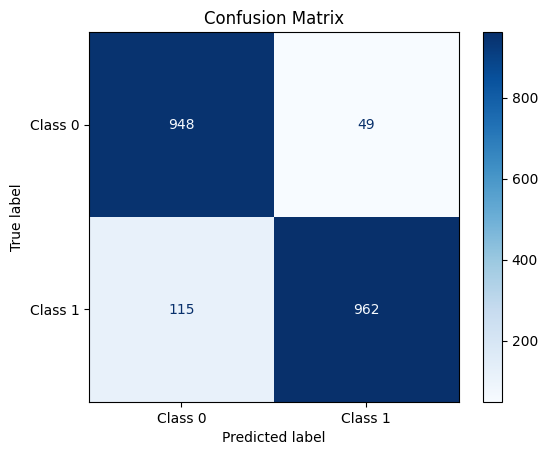

In [24]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load the best model
model.load_state_dict(torch.load('models/best_model_state.bin', weights_only=True))

# Evaluate on the test set
test_acc, test_loss = eval_model(model, test_loader, criterion, device)
print(f'Test loss: {test_loss} | Test accuracy: {test_acc}')

# Initialize empty lists to store predictions and true labels
all_preds = []
all_labels = []

# Generate predictions and collect labels
model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        _, preds = torch.max(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print the classification report
print(classification_report(all_labels, all_preds))

# Create and display the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
